**Run Expense Categorization Model (SVM, Naive Bayes, Decision Tree, KNN & BERT)**

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# %pip install 'accelerate>=0.26.0'
# %pip install 'accelerate>=0.26.0'

# %pip install torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1 --index-url https://download.pytorch.org/whl/cpu
%pip install transformers




     ---------------------------------------- 0.0/44.0 kB ? eta -:--:--
     ----------------- -------------------- 20.5/44.0 kB 640.0 kB/s eta 0:00:01
     -------------------------------------- 44.0/44.0 kB 718.1 kB/s eta 0:00:00
   ---------------------------------------- 0.0/12.0 MB ? eta -:--:--
   - -------------------------------------- 0.6/12.0 MB 17.6 MB/s eta 0:00:01
   ------ --------------------------------- 2.0/12.0 MB 26.0 MB/s eta 0:00:01
   ------------ --------------------------- 3.7/12.0 MB 29.4 MB/s eta 0:00:01
   ----------------- ---------------------- 5.2/12.0 MB 30.1 MB/s eta 0:00:01
   ---------------------- ----------------- 6.7/12.0 MB 32.9 MB/s eta 0:00:01
   --------------------------- ------------ 8.1/12.0 MB 32.4 MB/s eta 0:00:01
   -------------------------------- ------- 9.7/12.0 MB 32.7 MB/s eta 0:00:01
   -------------------------------------- - 11.7/12.0 MB 38.6 MB/s eta 0:00:01
   ---------------------------------------  12.0/12.0 MB 38.5 MB/s eta 0:

### Expense Categorization: 5-Model Comparison (DT, KNN, SVM, NB, BERT)

In [2]:

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,validation_curve,train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import joblib
import os

### Disable Weights & Biases logging to prevent login prompt ---

In [2]:
os.environ["WANDB_DISABLED"] = "true"

os.makedirs('saved_models', exist_ok=True)

### 1. DATA PREPARATION

In [3]:
csv_filename = r"C:\Users\USER\Documents\GitHub\classification/receipt_dataset_10000.csv"

# try:
    # print(f"Loading {csv_filename}...")
df = pd.read_csv(csv_filename)
    # print("✅ Data Loaded Successfully!")
# except FileNotFoundError:
#     print(f"❌ Error: {csv_filename} not found.")
#     sys.exit(1)

### Split Data
### Vectorization (Needed for all traditional ML models)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

vectorizer = TfidfVectorizer(
    analyzer='word',           
    ngram_range=(1, 3),        
    min_df=2,                  
    max_df=0.95,               
    lowercase=False,           
    token_pattern=r'(?u)\b\w+\b',
    max_features=1000  # 
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")
print("-" * 50)

Training samples: 4800, Testing samples: 1200
--------------------------------------------------


### 2. TRADITIONAL ML (4 Models)

In [5]:
print("Running Traditional Machine Learning Models...")
ml_results = {}

Running Traditional Machine Learning Models...


### --- A. Naive Bayes (NB) ---

In [6]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
nb_acc = accuracy_score(y_test, nb_model.predict(X_test_tfidf))
ml_results['Naive Bayes'] = nb_acc
print(f"✅ Naive Bayes Accuracy: {nb_acc:.4f}")




✅ Naive Bayes Accuracy: 0.9283


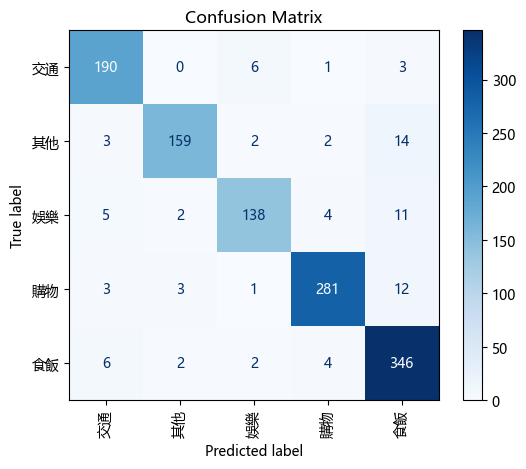

In [7]:
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei'] 

plt.rcParams['axes.unicode_minus'] = False

y_pred = nb_model.predict(X_test_tfidf)
cm = confusion_matrix(y_test, y_pred, labels=nb_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb_model.classes_)
disp.plot(xticks_rotation='vertical', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [8]:
print(classification_report(y_test, y_pred, target_names=nb_model.classes_))

              precision    recall  f1-score   support

          交通       0.92      0.95      0.93       200
          其他       0.96      0.88      0.92       180
          娛樂       0.93      0.86      0.89       160
          購物       0.96      0.94      0.95       300
          食飯       0.90      0.96      0.93       360

    accuracy                           0.93      1200
   macro avg       0.93      0.92      0.92      1200
weighted avg       0.93      0.93      0.93      1200



### --- B. Support Vector Machine (SVM) ---

In [9]:
svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(X_train_tfidf, y_train)
svm_acc = accuracy_score(y_test, svm_model.predict(X_test_tfidf))
# ml_results['SVM'] = svm_acc
print(f"✅ SVM Accuracy: {svm_acc:.4f}")

KeyboardInterrupt: 

In [10]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear']
}

grid = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_tfidf, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

svm_model = grid.best_estimator_
svm_acc = accuracy_score(y_test, svm_model.predict(X_test_tfidf))
print(f"✅ SVM Test Accuracy: {svm_acc:.4f}")

ml_results['SVM'] = svm_acc

Best parameters: {'C': 1, 'kernel': 'linear'}
Best CV accuracy: 0.9335416666666667
✅ SVM Test Accuracy: 0.9267


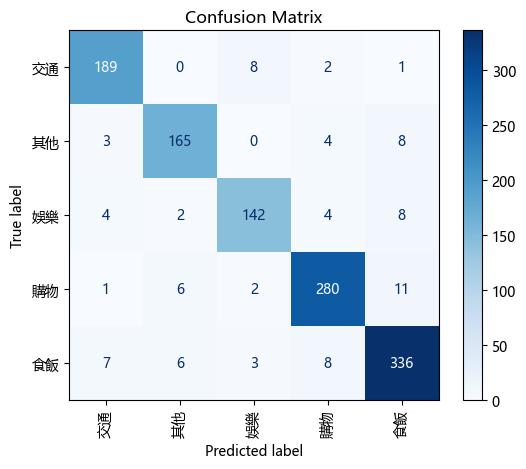

In [11]:
y_pred = svm_model.predict(X_test_tfidf)
cm = confusion_matrix(y_test, y_pred, labels=svm_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)
disp.plot(xticks_rotation='vertical', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

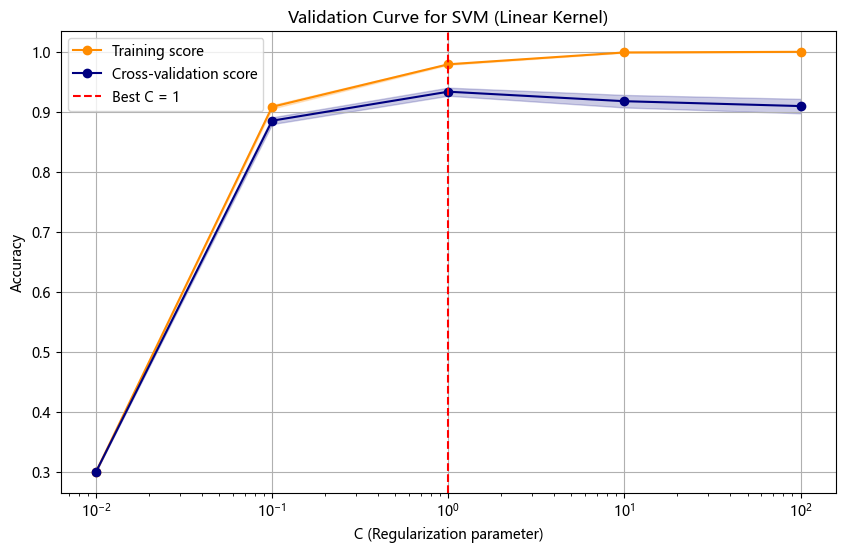

In [12]:
param_range = [0.01, 0.1, 1, 10, 100]

train_scores, val_scores = validation_curve(
    SVC(kernel='linear'),            
    X_train_tfidf, y_train,
    param_name="C",
    param_range=param_range,
    cv=5,                             
    scoring="accuracy",
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
val_mean   = np.mean(val_scores, axis=1)
val_std    = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Training score", color="darkorange", marker='o')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color="darkorange")

plt.plot(param_range, val_mean, label="Cross-validation score", color="navy", marker='o')
plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.2, color="navy")

plt.xscale('log')  
plt.xlabel('C (Regularization parameter)')
plt.ylabel('Accuracy')
plt.title('Validation Curve for SVM (Linear Kernel)')
best_C = grid.best_params_['C']
plt.axvline(x=best_C, color='red', linestyle='--', label=f'Best C = {best_C}')
plt.legend(loc="best")
plt.grid(True)
plt.show()

### --- C. Decision Tree (DT) ---


In [ ]:
# dt_model = DecisionTreeClassifier(random_state=42)
# dt_model.fit(X_train_tfidf, y_train)
# dt_acc = accuracy_score(y_test, dt_model.predict(X_test_tfidf))
# ml_results['Decision Tree'] = dt_acc
# print(f"✅ Decision Tree Accuracy: {dt_acc:.4f}")

✅ Decision Tree Accuracy: 0.9983


In [14]:
param_grid = {
    'max_depth': [13,14,15,16,17,18,19,20,None],
    'min_samples_leaf': [1, 2, 5, 10],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_tfidf, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

dt_model = grid.best_estimator_
dt_acc = accuracy_score(y_test, dt_model.predict(X_test_tfidf))
ml_results['Decision Tree'] = dt_acc
print(f"✅ Decision Tree Test Accuracy: {dt_acc:.4f}")

Best parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 2}
Best CV accuracy: 0.7664583333333332
✅ Decision Tree Test Accuracy: 0.7650


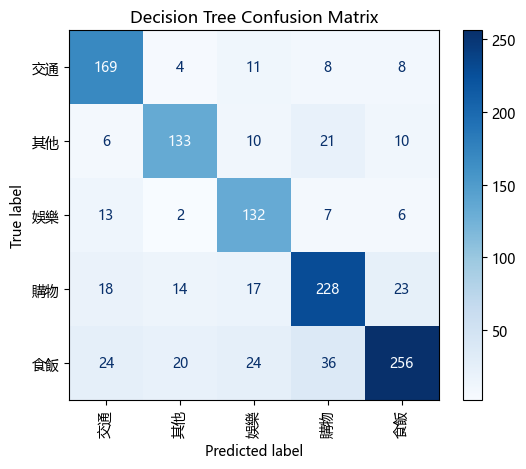

In [15]:
y_pred = dt_model.predict(X_test_tfidf)
cm = confusion_matrix(y_test, y_pred, labels=dt_model.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=dt_model.classes_)
disp.plot(xticks_rotation='vertical', cmap='Blues')
plt.title('Decision Tree Confusion Matrix')
plt.show()

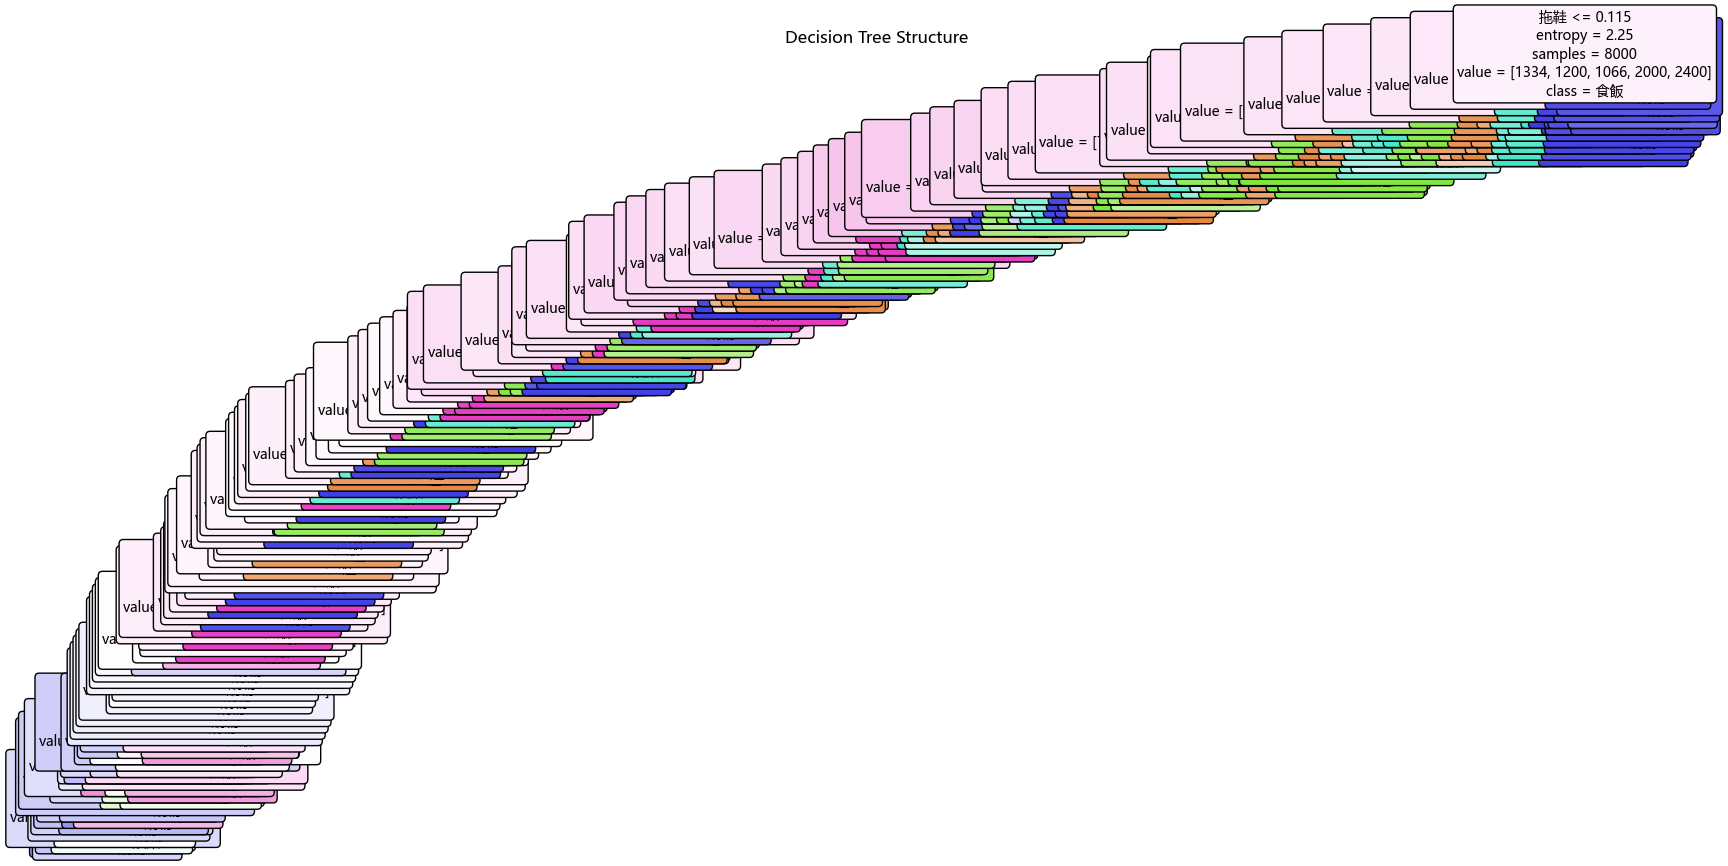

In [19]:
plt.figure(figsize=(20,10))  
plot_tree(dt_model, feature_names=vectorizer.get_feature_names_out(), 
          class_names=dt_model.classes_, filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree Structure')
plt.show()

Number of points: 9
train_mean length: 9


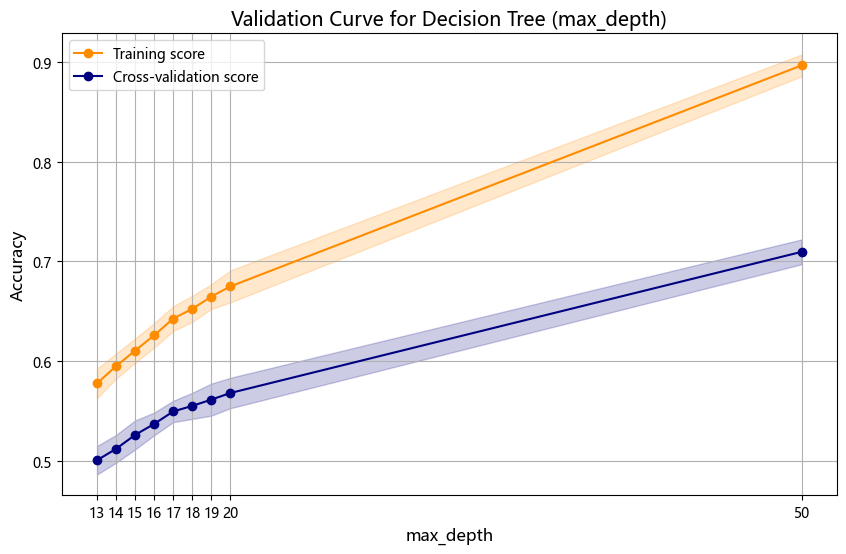

In [16]:
original_param_range = [13,14,15,16,17,18,19,20,50]  

plot_param_range = [x if x is not None else 50 for x in original_param_range]

train_scores, val_scores = validation_curve(
    DecisionTreeClassifier(random_state=42),
    X_train_tfidf, y_train,
    param_name="max_depth",
    param_range=original_param_range,   
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
val_mean   = np.mean(val_scores, axis=1)
val_std    = np.std(val_scores, axis=1)

print(f"Number of points: {len(plot_param_range)}")
print(f"train_mean length: {len(train_mean)}")

plt.figure(figsize=(10, 6))

plt.plot(plot_param_range, train_mean, label="Training score", color="darkorange", marker='o')
plt.fill_between(plot_param_range, train_mean - train_std, train_mean + train_std, 
                 alpha=0.2, color="darkorange")

plt.plot(plot_param_range, val_mean, label="Cross-validation score", color="navy", marker='o')
plt.fill_between(plot_param_range, val_mean - val_std, val_mean + val_std, 
                 alpha=0.2, color="navy")

plt.title('Validation Curve for Decision Tree (max_depth)', fontsize=14)
plt.xlabel('max_depth', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc="best")
plt.grid(True)

plt.xticks(plot_param_range)

plt.show()

### --- D. K-Nearest Neighbors (KNN) ---
### Using n_neighbors=3 for a simple baseline

In [22]:
knn_model = KNeighborsClassifier(n_neighbors=25)
knn_model.fit(X_train_tfidf, y_train)
knn_acc = accuracy_score(y_test, knn_model.predict(X_test_tfidf))
ml_results['KNN'] = knn_acc
print(f"✅ KNN Accuracy: {knn_acc:.4f}")

print("-" * 50)

✅ KNN Accuracy: 0.7567
--------------------------------------------------


k= 1 → Train: 1.0000 | Test: 0.5167
k= 2 → Train: 0.7715 | Test: 0.5083
k= 3 → Train: 0.7908 | Test: 0.5658
k= 4 → Train: 0.7923 | Test: 0.6058
k= 5 → Train: 0.7858 | Test: 0.6133
k= 6 → Train: 0.7852 | Test: 0.6342
k= 7 → Train: 0.7881 | Test: 0.6517
k= 8 → Train: 0.7935 | Test: 0.6717
k= 9 → Train: 0.8000 | Test: 0.6883
k=10 → Train: 0.8042 | Test: 0.7008
k=11 → Train: 0.8054 | Test: 0.7050
k=12 → Train: 0.8129 | Test: 0.7175
k=13 → Train: 0.8071 | Test: 0.7200
k=14 → Train: 0.8135 | Test: 0.7217
k=15 → Train: 0.8096 | Test: 0.7233
k=16 → Train: 0.8094 | Test: 0.7350
k=17 → Train: 0.8083 | Test: 0.7308
k=18 → Train: 0.8142 | Test: 0.7283
k=19 → Train: 0.8121 | Test: 0.7392
k=20 → Train: 0.8121 | Test: 0.7408
k=21 → Train: 0.8121 | Test: 0.7417
k=22 → Train: 0.8115 | Test: 0.7375
k=23 → Train: 0.8098 | Test: 0.7433
k=24 → Train: 0.8104 | Test: 0.7525
k=25 → Train: 0.8098 | Test: 0.7567
k=26 → Train: 0.8087 | Test: 0.7600
k=27 → Train: 0.8108 | Test: 0.7517
k=28 → Train: 0.8100 | Test:

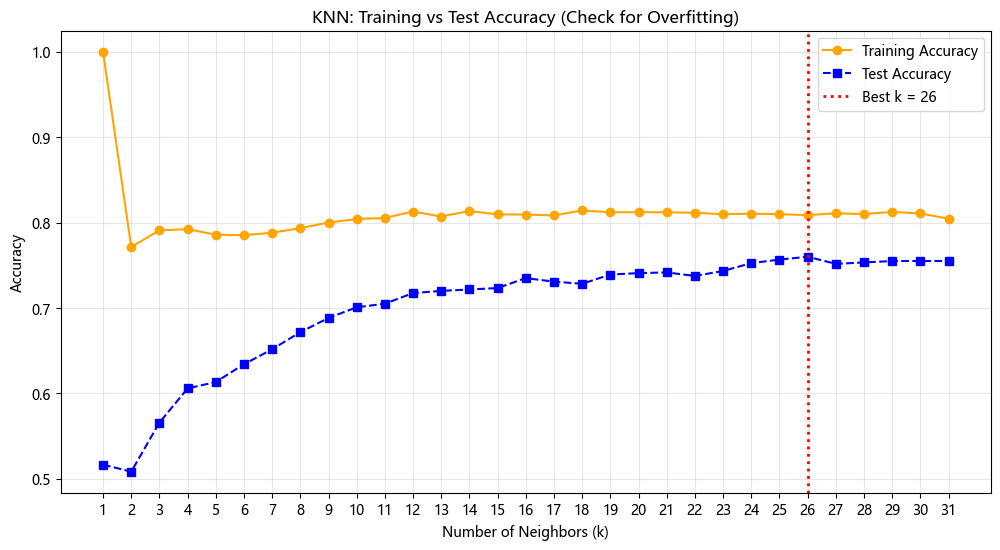

In [17]:
# k_values = []
# accuracies = []

k_values = list(range(1, 32))
train_accuracies = []
test_accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_tfidf, y_train)
    
    # 計算訓練準確率
    train_pred = knn.predict(X_train_tfidf)
    train_acc = accuracy_score(y_train, train_pred)
    train_accuracies.append(train_acc)
    
    # 計算測試準確率
    test_pred = knn.predict(X_test_tfidf)
    test_acc = accuracy_score(y_test, test_pred)
    test_accuracies.append(test_acc)
    
    print(f"k={k:2d} → Train: {train_acc:.4f} | Test: {test_acc:.4f}")

# 找到測試集最好的 k
best_k = k_values[test_accuracies.index(max(test_accuracies))]
best_test_acc = max(test_accuracies)

print(f"\n🏆 Best k: {best_k} with Test Accuracy: {best_test_acc:.4f}")

# 繪圖：兩條線一起看
plt.figure(figsize=(12, 6))
plt.plot(k_values, train_accuracies, marker='o', linestyle='-', color='orange', label='Training Accuracy')
plt.plot(k_values, test_accuracies, marker='s', linestyle='--', color='blue', label='Test Accuracy')
plt.title('KNN: Training vs Test Accuracy (Check for Overfitting)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid(True, alpha=0.3)
plt.axvline(x=best_k, color='red', linestyle=':', linewidth=2, label=f'Best k = {best_k}')
plt.legend()
plt.show()

### --- E. Logistic Regression ---

In [ ]:
# logistic_model = LogisticRegression(max_iter=1000, C=5)

# logistic_model.fit(X_train_tfidf, y_train)
# logistic_acc = accuracy_score(y_test, logistic_model.predict(X_test_tfidf))
# ml_results['Logistic Regression'] = logistic_acc

# print(f"✅ Logistic Regression Accuracy: {logistic_acc:.4f}")

# print("-" * 50)


✅ Logistic Regression Accuracy: 1.0000
--------------------------------------------------


In [18]:
param_grid = {
    'C': [0.05, 0.1 , 0.5 , 1 , 5],
    'penalty': ['l1', 'l2'],
    'solver': ['saga'] 
}

grid = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), 
                    param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_tfidf, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

logistic_model = grid.best_estimator_
logistic_acc = accuracy_score(y_test, logistic_model.predict(X_test_tfidf))
ml_results['Logistic Regression'] = logistic_acc
print(f"✅ Logistic Regression Test Accuracy: {logistic_acc:.4f}")

Best parameters: {'C': 5, 'penalty': 'l1', 'solver': 'saga'}
Best CV accuracy: 0.9550000000000001
✅ Logistic Regression Test Accuracy: 0.9500


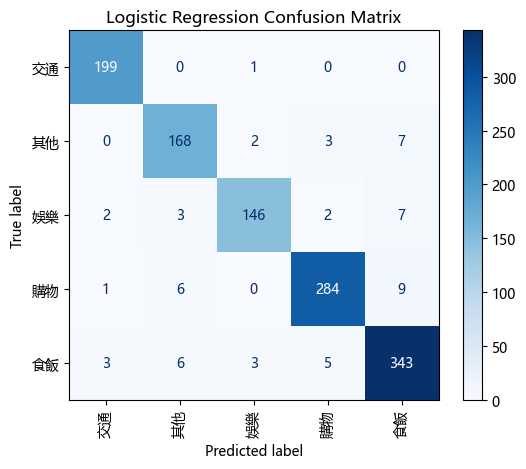

In [19]:
y_pred = logistic_model.predict(X_test_tfidf)
cm = confusion_matrix(y_test, y_pred, labels=logistic_model.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=logistic_model.classes_)
disp.plot(xticks_rotation='vertical', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

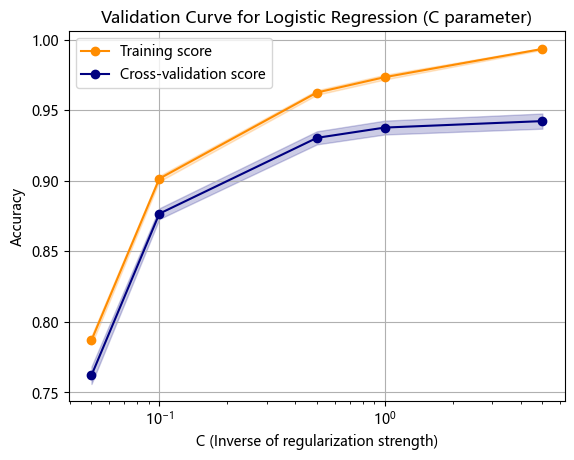

In [20]:
param_range = [0.05, 0.1 , 0.5 , 1 , 5]

train_scores, val_scores = validation_curve(
    LogisticRegression(max_iter=1000, solver='saga', penalty='l2'),
    X_train_tfidf, y_train, param_name="C", param_range=param_range,
    cv=5, scoring="accuracy", n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std   = np.std(val_scores, axis=1)


# plt.figure(figsize=(10,6))
plt.plot(param_range, train_mean, label="Training score", color="darkorange", marker='o')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color="darkorange")
plt.plot(param_range, val_mean, label="Cross-validation score", color="navy", marker='o')
plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.2, color="navy")

plt.xscale('log')
plt.xlabel('C (Inverse of regularization strength)')
plt.ylabel('Accuracy')
plt.title('Validation Curve for Logistic Regression (C parameter)')
plt.legend(loc="best")
plt.grid(True)
plt.show()

### 3. DEEP LEARNING (BERT)

In [32]:
print("Initializing Deep Learning (BERT)...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model_name = "bert-base-multilingual-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=5)
model.to(device)

class ExpenseDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=64):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            text, add_special_tokens=True, max_length=self.max_len,
            padding='max_length', truncation=True, return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# train_dataset = ExpenseDataset(X_train.tolist(), y_train.tolist(), tokenizer)
# test_dataset = ExpenseDataset(X_test.tolist(), y_test.tolist(), tokenizer)

# training_args = TrainingArguments(
#     output_dir='./results', num_train_epochs=3, per_device_train_batch_size=8,
#     logging_dir='./logs', logging_steps=10,
#     report_to="none"
# )

# trainer = Trainer(
#     model=model, args=training_args, train_dataset=train_dataset, eval_dataset=test_dataset,
#     compute_metrics=lambda p: {"accuracy": accuracy_score(p.label_ids, p.predictions.argmax(-1))}
# )

# print("Training BERT model (No Login Required)...")
# trainer.train()

# bert_eval = trainer.evaluate()
# bert_acc = bert_eval['eval_accuracy']
# ml_results['BERT'] = bert_acc
# print(f"✅ BERT Accuracy: {bert_acc:.4f}")
# print("-" * 50)


Initializing Deep Learning (BERT)...
Using device: cpu


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# ==========================================
# 4. PLOTTING COMPARISON
# ==========================================

Generating 5-Model Comparison Plot...


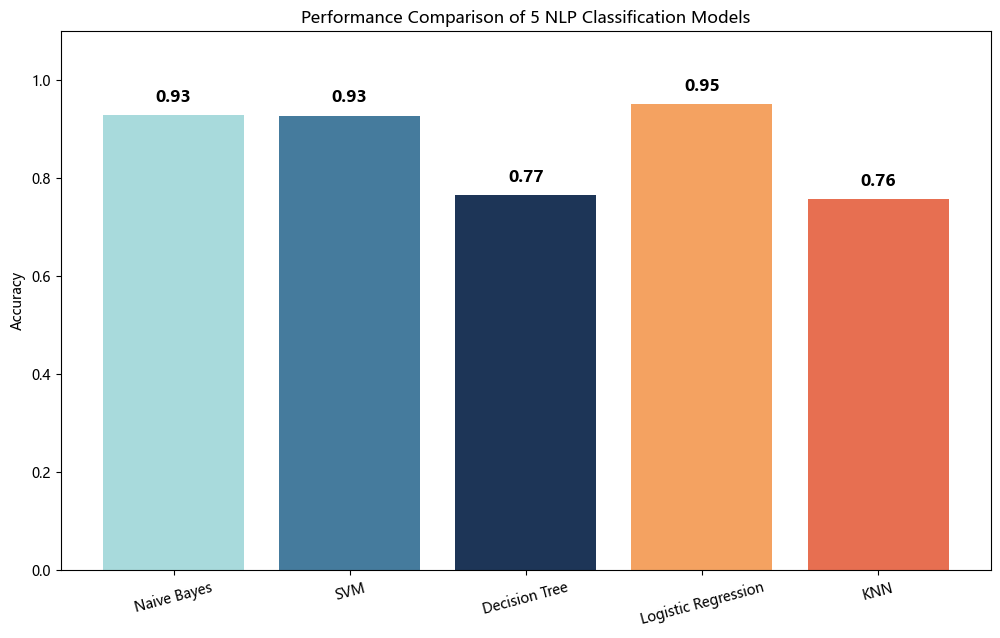

In [23]:
print("Generating 5-Model Comparison Plot...")
models = list(ml_results.keys())
accuracies = list(ml_results.values())

plt.figure(figsize=(12, 7))
# Use a color palette to distinguish ML types
colors = ['#A8DADC', '#457B9D', '#1D3557', '#F4A261', '#E76F51']
bars = plt.bar(models, accuracies, color=colors)
plt.ylim(0, 1.1)
plt.ylabel('Accuracy')
plt.title('Performance Comparison of 5 NLP Classification Models')
plt.xticks(rotation=15)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}",
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.show()

# ==========================================
# 5. PREDICTION FUNCTION
# ==========================================

In [24]:

CATEGORY_MAP = {
    0: "Groceries (雜貨/超市購物)", 1: "Transportation (交通)",
    2: "Utilities (公用事業)", 3: "Entertainment (娛樂)",
    4: "Food & Drinks (食物與飲料)"
}

def predict_expense(text_input):
    """Predicts expense category using all five models."""
    global logistic_model,nb_model, svm_model, dt_model, knn_model, model, vectorizer, tokenizer, device, CATEGORY_MAP

    # --- Vectorization ---
    vec = vectorizer.transform([text_input])

    # --- ML Predictions ---
    nb_p = nb_model.predict(vec)[0]
    svm_p = svm_model.predict(vec)[0]
    dt_p = dt_model.predict(vec)[0]
    knn_p = knn_model.predict(vec)[0]
    logistic_p = logistic_model.predict(vec)[0]

    # --- DL Prediction (BERT) ---
    inputs = tokenizer(text_input, return_tensors="pt", truncation=True, padding=True, max_length=64).to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
    bert_p = logits.argmax().item()

    print(f"\n--- Prediction for: '{text_input}' ---")
    # print(f"**Naive Bayes:** [{nb_p}] {CATEGORY_MAP[nb_p]}")
    # print(f"**SVM:** [{svm_p}] {CATEGORY_MAP[svm_p]}")
    # print(f"**Decision Tree:** [{dt_p}] {CATEGORY_MAP[dt_p]}")
    # print(f"**KNN:** [{knn_p}] {CATEGORY_MAP[knn_p]}")
    # print(f"**BERT:** [{bert_p}] {CATEGORY_MAP[bert_p]}")

    print(f"**Naive Bayes:** [{nb_p}] ")
    print(f"**SVM:** [{svm_p}] ")
    print(f"**Decision Tree:** [{dt_p}] ")
    print(f"**KNN:** [{knn_p}] ")
    print(f"**BERT:** [{bert_p}]")
    print(f"**Logistic Regression:** [{logistic_p}]")
    
    print("-" * 40)

# print("--- Running Predictions on Test Inputs ---")
# predict_expense('Sushi and beer with friends HKD120')
# predict_expense('Uber $110.50')
# predict_expense('Electric bill')
# predict_expense('咖哩牛腩飯')
# predict_expense('米線')
# predict_expense('Concert tickets for VIP seat USD900')
# predict_expense('Socks')
# predict_expense('恐龍毛公仔')

In [26]:
# Test with Examples
import pandas as pd
import requests
from IPython.display import display
import time


API_URL = "http://127.0.0.1:8000/ai_model/GetOcrResultCategorizer"

csv_filename = r"C:\Users\USER\Documents\GitHub\classification/test_data_cate.csv"

df = pd.read_csv(csv_filename, encoding='utf-8')


# df = pd.read_csv(r'C:\Users\USER\Documents\GitHub\classification\Test_data_cate.csv', encoding='utf-8-sig')
df = df.head(27).reset_index(drop=True)

print(f"準備測試 {len(df)} 張圖片\n")
display(df)

results = []
model_correct = {
    "Naive Bayes": 0,
    "SVM": 0,
    "Decision Tree": 0,
    "KNN": 0,
    "Logistic Regression": 0
}
total = len(df)

for idx, row in df.iterrows():
    image_path = row['Path']     
    true_label = row['label']    
    
    print(f"正在處理第 {idx+1}/{total} 張: {image_path} → 真實標籤: {true_label}")
    
    try:
        with open(image_path, 'rb') as img_file:
            files = {'image': img_file}
            data = {'ocr_engine': 'easyocr'}  
            
            response = requests.post(
                API_URL,
                files=files,
                data=data,
                timeout=60
            )
        
        if response.status_code != 200:
            print(f"  API 錯誤: {response.status_code} - {response.text}")
            results.append({"image": image_path, "true": true_label, "api_error": response.text})
            continue
            
        result_json = response.json()
        
        predictions = result_json.get("predictions", {})
        total_amount = result_json.get("TotalAmount", None)
        input_text = result_json.get("input", "")[:100] + "..."  
        
        correct_models = []
        for model, pred_label in predictions.items():
            if pred_label == true_label:
                model_correct[model] += 1
                correct_models.append(model)
        
        print(f"  提取金額: {total_amount} | 正確模型: {', '.join(correct_models) or '無'}")
        
        results.append({
            "image": image_path,
            "true_label": true_label,
            "predictions": predictions,
            "TotalAmount": total_amount,
            "input_preview": input_text
        })
        
    except requests.exceptions.Timeout:
        print(f"  第 {idx+1} 張逾時（>60秒），跳過")
        results.append({"image": image_path, "true": true_label, "error": "Timeout"})
    except Exception as e:
        print(f"  錯誤: {e}")
        results.append({"image": image_path, "true": true_label, "error": str(e)})
    
    # 每張之間休息一下，避免 server 負擔過重（可選）
    time.sleep(1)








準備測試 27 張圖片



,Path,label
0,test_img/1.jpg,食飯
1,test_img/2.jpg,其他
2,test_img/3.jpg,食飯
3,test_img/4.jpg,食飯
4,test_img/5.jpg,食飯
5,test_img/6.jpeg,食飯
6,test_img/7.jpeg,食飯
7,test_img/8.jpg,購物
8,test_img/9.jpeg,購物
9,test_img/10.jpeg,食飯


正在處理第 1/27 張: test_img/1.jpg → 真實標籤: 食飯
  提取金額: None | 正確模型: Naive Bayes, SVM, KNN, Logistic Regression
正在處理第 2/27 張: test_img/2.jpg → 真實標籤: 其他
  提取金額: 41.0 | 正確模型: 無
正在處理第 3/27 張: test_img/3.jpg → 真實標籤: 食飯
  提取金額: 0.0 | 正確模型: Naive Bayes, SVM, Logistic Regression
正在處理第 4/27 張: test_img/4.jpg → 真實標籤: 食飯
  提取金額: None | 正確模型: Naive Bayes, SVM, KNN, Logistic Regression
正在處理第 5/27 張: test_img/5.jpg → 真實標籤: 食飯
  提取金額: None | 正確模型: Naive Bayes, SVM, KNN, Logistic Regression
正在處理第 6/27 張: test_img/6.jpeg → 真實標籤: 食飯
  提取金額: None | 正確模型: Naive Bayes, SVM, KNN, Logistic Regression
正在處理第 7/27 張: test_img/7.jpeg → 真實標籤: 食飯
  提取金額: None | 正確模型: Naive Bayes, SVM, KNN, Logistic Regression
正在處理第 8/27 張: test_img/8.jpg → 真實標籤: 購物
  提取金額: 50.0 | 正確模型: Decision Tree
正在處理第 9/27 張: test_img/9.jpeg → 真實標籤: 購物
  提取金額: 80.0 | 正確模型: Decision Tree
正在處理第 10/27 張: test_img/10.jpeg → 真實標籤: 食飯
  提取金額: 104.0 | 正確模型: Naive Bayes, SVM, Logistic Regression
正在處理第 11/27 張: test_img/11.jpeg → 真實標籤: 食飯
  提取金額: 205.0 | 正確模型

In [27]:
result_df = pd.DataFrame(results)
display(result_df)

,image,true_label,predictions,TotalAmount,input_preview
0,test_img/1.jpg,食飯,"{'Naive Bayes': '食飯', 'SVM': '食飯', 'Decision T...",NaN,伊勢堂 收銀員: Admin 流水號: oooo31359泉號: 5 單號: 00382/1...
1,test_img/2.jpg,其他,"{'Naive Bayes': '娛樂', 'SVM': '食飯', 'Decision T...",41.0,COMPAN/ #酴7a)M1; 誦 400709 收款 ID: 7994010012402...
2,test_img/3.jpg,食飯,"{'Naive Bayes': '食飯', 'SVM': '食飯', 'Decision T...",0.0,Saizeriza 薩莉亞g式綬蔭 Salzeriya $mp |b.49-5. Level...
3,test_img/4.jpg,食飯,"{'Naive Bayes': '食飯', 'SVM': '食飯', 'Decision T...",NaN,0t0 Panash 葵興潞28k新郜會k場4攫480號舖 電話 24310268 : 01...
4,test_img/5.jpg,食飯,"{'Naive Bayes': '食飯', 'SVM': '食飯', 'Decision T...",NaN,e 蠱#; A 蒙 盞 ; _ o 響 = 馨 g g 莖 8 e := 心 = < o o...
5,test_img/6.jpeg,食飯,"{'Naive Bayes': '食飯', 'SVM': '食飯', 'Decision T...",NaN,| 卜 ! g 螽 薹 壼 畿 蓋% 黑i E # * { ' 羈 瓣| 聿 盞 吾 g ~...
6,test_img/7.jpeg,食飯,"{'Naive Bayes': '食飯', 'SVM': '食飯', 'Decision T...",NaN,m 扣 . 蠱 昱 =- = 二 = 乙 囂 8 = ; $ _ 耄 紫 葵 _ 3 言 :...
7,test_img/8.jpg,購物,"{'Naive Bayes': '食飯', 'SVM': '食飯', 'Decision T...",50.0,惠康wellcome 宏福花園 2 電話:27570317 水動樂電解質補充飲品 10.00...
8,test_img/9.jpeg,購物,"{'Naive Bayes': '食飯', 'SVM': '食飯', 'Decision T...",80.0,"萬寧 mannings 新界沙田火炭駿洋邯驗洋商埸6層613號, 電 話;246?2342 ..."
9,test_img/10.jpeg,食飯,"{'Naive Bayes': '食飯', 'SVM': '食飯', 'Decision T...",104.0,n尚 沙日連(城7爛魚尚 竄骷 2523.)80( 外賣) 2 三文魚小倦(12件) $40...


In [28]:
print("\n" + "="*60)
print("27 張圖片測試結果 - 各模型正確率")
print("="*60)

accuracy = {model: round(count / total * 100, 2) for model, count in model_correct.items()}

for model in ["Naive Bayes", "SVM", "Decision Tree", "KNN", "Logistic Regression"]:
    print(f"{model:20} : {model_correct[model]}/{total} ({accuracy[model]}%)")


27 張圖片測試結果 - 各模型正確率
Naive Bayes          : 20/27 (74.07%)
SVM                  : 20/27 (74.07%)
Decision Tree        : 6/27 (22.22%)
KNN                  : 15/27 (55.56%)
Logistic Regression  : 20/27 (74.07%)


In [60]:
print("\n--- 排名 ---")
for model, pct in sorted(accuracy.items(), key=lambda x: -x[1]):
    print(f"{model}: {pct}%")


--- 排名 ---
SVM: 77.78%
Decision Tree: 77.78%
Logistic Regression: 77.78%
Naive Bayes: 74.07%
KNN: 33.33%


In [25]:


# Save the TF-IDF vectorizer (required for all traditional ML models)
joblib.dump(vectorizer, 'saved_models/tfidf_vectorizer.pkl')

# Save traditional ML models
joblib.dump(nb_model, 'saved_models/nb_model.pkl')
joblib.dump(svm_model, 'saved_models/svm_model.pkl')
joblib.dump(dt_model, 'saved_models/dt_model.pkl')
joblib.dump(knn_model, 'saved_models/knn_model.pkl')
joblib.dump(logistic_model, 'saved_models/logistic_model.pkl')

['saved_models/logistic_model.pkl']